# Import librarys

In [1]:
from keras.models import load_model
from keras.metrics import MeanSquaredError
from sklearn.base import BaseEstimator
from keras.models import Model
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import keras
from keras.callbacks import History
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import keras
from scikeras.wrappers import KerasRegressor
from keras.layers import Input
from keras.optimizers import RMSprop
import yfinance as yf
from matplotlib.backends.backend_pdf import PdfPages
import pickle

# CSV einlesen

In [2]:
def download_stock_data(stock_symbols, start_date, end_date, output_file):
    with open(output_file, 'w') as f:
        # Write column headings
        f.write('Date,Open,High,Low,Close,Volume\n')
        
        for symbol in stock_symbols:
            # Load the share data for every symbol and the defined time period
            stock_data = yf.download(symbol, start=start_date, end=end_date)
            stock_data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']]  # Auswahl der gewünschten Spalten
            stock_data.to_csv(f, header=False)  # Schreiben der Daten in die Datei


In [3]:
# Define time period and symbol
stock_symbols = ['EOAN.DE']
start_date = '2000-01-01'
end_date = '2018-12-31'
output_file = 'stock_data.csv'

# Load and store the share data
download_stock_data(stock_symbols, start_date, end_date, output_file)

# Search and delete empty rows in the CSV file
with open(output_file, 'r') as file:
    lines = file.readlines()

# Filter empty rows
lines = [line.strip() for line in lines if line.strip()]

# Overwrite the file with the cleaned rows
with open(output_file, 'w') as file:
    file.write('\n'.join(lines))

[*********************100%%**********************]  1 of 1 completed


In [4]:
# load CSV
df = pd.read_csv('stock_data.csv')

# transform date to index
df.set_index('Date', inplace=True)

# Duplicate the dataset
#df = pd.concat([df] * 2, ignore_index=True)

# Show first rows
print(df)
print(len(df))

                 Open       High        Low      Close    Volume
Date                                                            
2000-01-03  14.938904  14.999324  14.506899  14.606593   4605397
2000-01-04  14.682118  14.682118  13.745604  14.289386   5286301
2000-01-05  14.029579  14.558257  13.957075  14.500857   6279352
2000-01-06  14.518983  14.923799  14.518983  14.700244   5856699
2000-01-07  14.802959  15.102039  14.597530  14.802959   5382206
...               ...        ...        ...        ...       ...
2018-12-19   8.897000   8.999000   8.883000   8.965000  10697273
2018-12-20   8.889000   8.944000   8.813000   8.895000  12874187
2018-12-21   8.915000   8.939000   8.783000   8.864000  18955695
2018-12-27   8.829000   8.830000   8.419000   8.524000  14212275
2018-12-28   8.550000   8.643000   8.498000   8.627000   5684732

[4865 rows x 5 columns]
4865


In [5]:
# Check, if there are any missing numbers
missing_values_before = df.isnull().values.any()

# Treat missing values with the mean of the previous and the following row
for column in df.columns:
    missing_values = df[column].isnull()
    df.loc[missing_values, column] = (df[column].shift() + df[column].shift(-1)) / 2

# Check, if there are missing values after the Treatment
missing_values_after = df.isnull().values.any()

# Output of the missing values before and after the Treatment
print("Fehlende Werte vor der Behandlung gefunden:", missing_values_before)
print("Fehlende Werte nach der Behandlung gefunden:", missing_values_after)

Fehlende Werte vor der Behandlung gefunden: False
Fehlende Werte nach der Behandlung gefunden: False


In [6]:
# show first rows
print(df.head())

                 Open       High        Low      Close   Volume
Date                                                           
2000-01-03  14.938904  14.999324  14.506899  14.606593  4605397
2000-01-04  14.682118  14.682118  13.745604  14.289386  5286301
2000-01-05  14.029579  14.558257  13.957075  14.500857  6279352
2000-01-06  14.518983  14.923799  14.518983  14.700244  5856699
2000-01-07  14.802959  15.102039  14.597530  14.802959  5382206


# Data normalization

In [7]:
# Copy the data frame and remove the column "date"
nf = df.copy()

# Remove the index name
nf.index.name = None

# normalize the data, except the "date" (index)
scaler = MinMaxScaler()
nf_normalized = scaler.fit_transform(nf)

# Create a new data frame with the normalized data and the original index
nf = pd.DataFrame(nf_normalized, columns=nf.columns, index=nf.index)

# Show the normalized data
print(nf.head())

# Show the length of the data frame
print("Länge des Datensatzes:", len(nf))

                Open      High       Low     Close    Volume
2000-01-03  0.222673  0.220433  0.214866  0.213617  0.034988
2000-01-04  0.216248  0.212597  0.195653  0.205711  0.040161
2000-01-05  0.199920  0.209538  0.200990  0.210982  0.047706
2000-01-06  0.212166  0.218568  0.215171  0.215951  0.044495
2000-01-07  0.219271  0.222971  0.217153  0.218510  0.040890
Länge des Datensatzes: 4865


In [8]:
# save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# read predicting sequence

In [9]:
# Define time period and output file
start_date = '2018-10-01'
end_date = '2018-12-31'
output_file = 'stock_data_pre.csv'

# Load and store the share data
download_stock_data(stock_symbols, start_date, end_date, output_file)

# Search and delete the empty rows in the CSV file
with open(output_file, 'r') as file:
    lines = file.readlines()

# Filter the empty rows
lines = [line.strip() for line in lines if line.strip()]

# Overwrite the file with the cleaned rows
with open(output_file, 'w') as file:
    file.write('\n'.join(lines))

[*********************100%%**********************]  1 of 1 completed


In [10]:
# load CSV
dfPre = pd.read_csv('stock_data_pre.csv')

# Drop empty rows
dfPre.dropna(inplace=True)

# transform date to index
dfPre.set_index('Date', inplace=True)

# Check the number of rows
num_rows = dfPre.shape[0]

# If more than 60 rows, keep the last 60 rows
if num_rows > 60:
    dfPre = dfPre.tail(60)

# Show first rows
print(dfPre.head())

             Open   High    Low  Close    Volume
Date                                            
2018-10-02  8.676  8.779  8.670  8.755   7893203
2018-10-04  8.670  8.728  8.620  8.680  11358580
2018-10-05  8.681  8.737  8.603  8.643  12532924
2018-10-08  8.600  8.664  8.513  8.532   7409361
2018-10-09  8.527  8.631  8.468  8.601   9414644


In [11]:
# Check, if there are missing values before the treatment
missing_values_beforePre = dfPre.isnull().values.any()

# Treat missing values for all columns with the mean of the previous and following row
for column in df.columns:
    missing_valuesPre = dfPre[column].isnull()
    dfPre.loc[missing_valuesPre, column] = (dfPre[column].shift() + dfPre[column].shift(-1)) / 2

# Check, if there are missing values after the treatment
missing_values_afterPre = dfPre.isnull().values.any()

# Output of the missing values before and after the treatment
print("Fehlende Werte vor der Behandlung gefunden:", missing_values_beforePre)
print("Fehlende Werte nach der Behandlung gefunden:", missing_values_afterPre)

# show lenth of data set
print(len(dfPre))

Fehlende Werte vor der Behandlung gefunden: False
Fehlende Werte nach der Behandlung gefunden: False
60


# Data normalization prediction data

In [12]:
# Copy the data frame and remove the column "date"
nfPre = dfPre.copy()

# Remove the index name
nfPre.index.name = None

# Normalize the data, except the "date" (Index)
nfPre_normalized = scaler.fit_transform(nfPre)

# Create a data frame with the normalized data and the original index
nfPre = pd.DataFrame(nfPre_normalized, columns=nfPre.columns, index=nfPre.index)

# Convert DataFrame to NumPy array
nfPre = nfPre.to_numpy()

# Show length of the data frame
print("Länge des Datensatzes:", len(nfPre))


Länge des Datensatzes: 60


# Create Sequences

In [13]:
# Function to create sequenences for LSTM model
def create_sequences(data_input, seq_length):
    data = data_input
    X, y = [], []
    for i in range(len(data) - seq_length - 252):
        X.append(data[i:i+seq_length])
        y.append(data.iloc[i+seq_length+252]) # acess to Close-Value of the 252th row
    return np.array(X), np.array(y)

In [14]:
# create sequence
sequence_length = 60
X, y = create_sequences(nf, sequence_length)

# Split the data in Training, Test and validation

In [15]:
# Split data in training and test (80% training, 20% test)
train_data, test_data = train_test_split(nf, test_size=0.2, shuffle=False)

# Split data in training and validation (80% training, 20% validation)
train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=False)

# Split the train data in sequences
X_train, y_train = create_sequences(train_data, sequence_length)

# Split the validation data in sequences
X_val, y_val = create_sequences(val_data, sequence_length)

# Split the test data in sequences
X_test, y_test = create_sequences(test_data, sequence_length)

# show training, validation and test sets
print("Trainingsdaten:", len(train_data))
print("Validierungsdaten:", len(val_data))
print("Testdaten:", len(test_data))

Trainingsdaten: 3113
Validierungsdaten: 779
Testdaten: 973


In [16]:
# Define train_size, val_size and test_size
train_size = len(train_data)
val_size = len(val_data)
test_size = len(test_data)
nfPre_size = len(nfPre)

# Extract features and target variables for training, validation, and test sets
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
# Add a external dimension
X_pre = np.expand_dims(nfPre[:nfPre_size], axis=0)


In [17]:
# Convert the train, val and prediction data into tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)
X_pre_tensor = tf.convert_to_tensor(X_pre, dtype=tf.float32)

# Define model

In [18]:
# Define the hyper parameters
units = 25
learning_rate = 0.003
optimizer = Adam(learning_rate=learning_rate)
dropout_rate = 0.5
batch_size = 128
epochs = 10

In [19]:
# Define input layer
input_layer = Input(shape=(sequence_length, 5))

# create model
model = Sequential([
    LSTM(units=units, return_sequences=True),
    Dropout(dropout_rate),
    LSTM(units=units, return_sequences=False),
    Dropout(dropout_rate),
    Dense(units=5)  # Anpassen der Anzahl der Ausgabeneinheiten auf 5 für 5 Input-Variablen
])

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Evaluate model

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1124 - val_loss: 0.0076
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0314 - val_loss: 0.0067
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0270 - val_loss: 0.0112
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0253 - val_loss: 0.0085
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0214 - val_loss: 0.0059
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0218 - val_loss: 0.0119
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0185 - val_loss: 0.0074
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0159 - val_loss: 0.0052
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0145 - val_loss: 0.0071
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0141 - val_loss: 0.0092


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 25)         │         3,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 25)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 25)             │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,992 (97.63 KB)

 Trainable params: 8,330 (32.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,662 (65.09 KB)

None


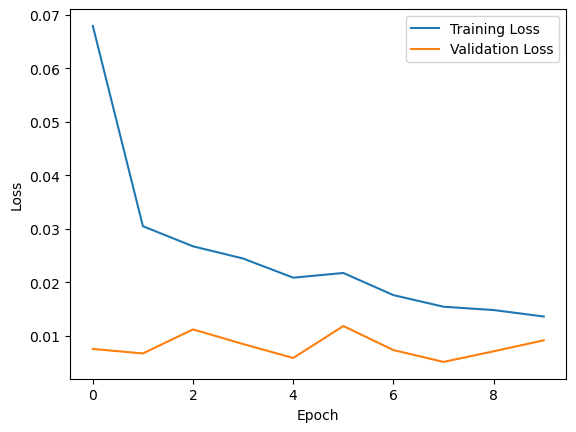

In [20]:
# Retrieve the history object
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

# Show the model summary
print(model.summary())

# Plot the loss function during the training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Modell speichern

In [21]:
for symbol in stock_symbols:
    model.save(f'Predict1Year_{symbol}.h5.keras')

# Predictions X-test

In [22]:
predictions = model.predict(X_test)
print(f'Prediction: {predictions}')
print(len(predictions))
print(len(X_test))

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Prediction: [[0.19244462 0.20682749 0.19528179 0.1929348  0.06724662]
 [0.1916725  0.20604938 0.19434132 0.19223282 0.06731759]
 [0.1906757  0.20522137 0.19352326 0.19134645 0.06717893]
 ...
 [0.15097028 0.17097427 0.16068509 0.1522576  0.05574185]
 [0.15094754 0.17094569 0.1600123  0.15253234 0.0561629 ]
 [0.15058187 0.17065251 0.15914793 0.15245353 0.05636139]]
661
661


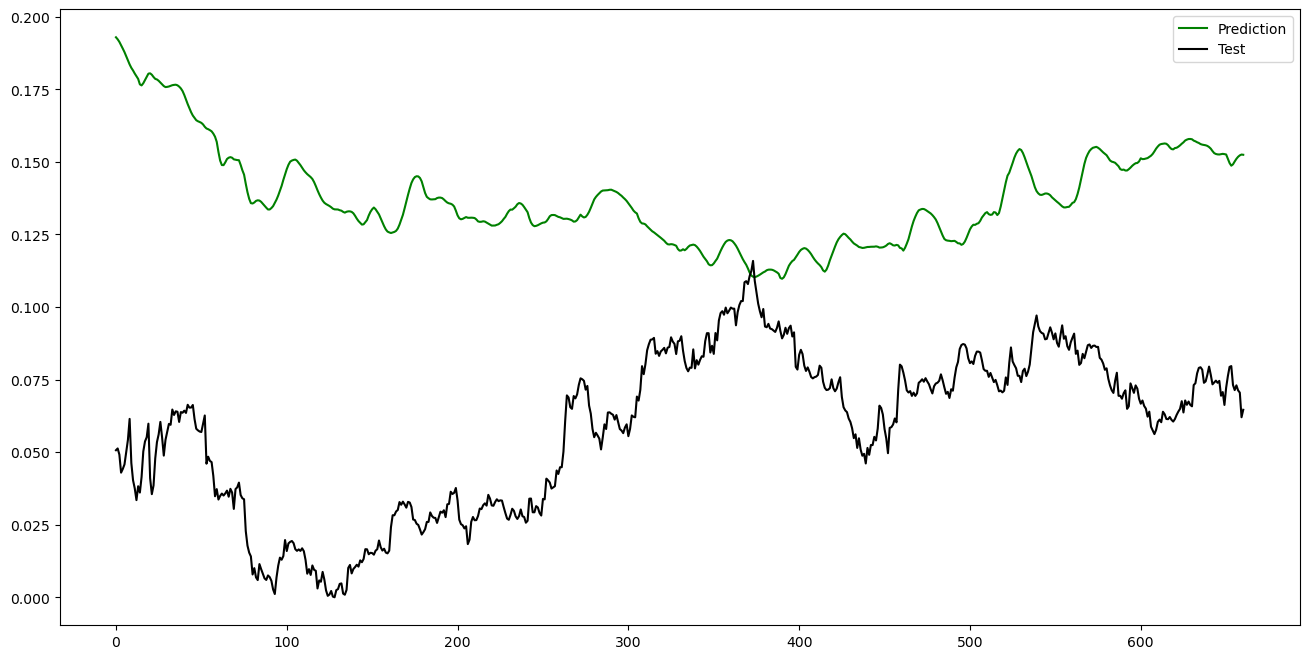

In [23]:
plt.figure(figsize=(16, 8))
plt.plot(predictions[:,-2], color="green", label="Prediction")
plt.plot(y_test[:,-2], color="black", label="Test")
plt.legend()
plt.show()

# Compare test dataset

# Prediction for the unkonown sequence

In [24]:
predictions = model.predict(X_pre)
prediction_20_days_ahead = predictions[0][-2]
print(f'Prediction: {predictions}')
print(len(predictions))
print(len(X_pre))
print(prediction_20_days_ahead)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: [[1.0304682 1.0202007 1.0131614 1.0636513 0.0897987]]
1
1
1.0636513


# Transform back into monetary values

In [25]:
# Inverse transformation of the predictions
predictions_original_scale = scaler.inverse_transform(predictions)
print(predictions_original_scale)
prediction_20_days_ahead = predictions_original_scale[0][-2]

# shape a 1-Dimensional array
predictions_close = predictions_original_scale[:, -1]  # Extract only the close values

# Show values of inverse transformation
print("Zurücktransformierte Vorhersagen:")
print(predictions_original_scale)
print(prediction_20_days_ahead)

[[9.3155050e+00 9.3288279e+00 9.2045298e+00 9.2908316e+00 7.1294545e+06]]
Zurücktransformierte Vorhersagen:
[[9.3155050e+00 9.3288279e+00 9.2045298e+00 9.2908316e+00 7.1294545e+06]]
9.290832


# read test CSV from 2019

In [26]:
# Define time period and output file
start_date = '2019-01-01'
end_date = '2019-12-31'
output_file = 'stock_data_2019.csv'

# Load and store the share data
download_stock_data(stock_symbols, start_date, end_date, output_file)

# Search and delete empty rows in the CSV file
with open(output_file, 'r') as file:
    lines = file.readlines()

# Filter empty rows
lines = [line.strip() for line in lines if line.strip()]

# Overwrite the file with the cleaned data
with open(output_file, 'w') as file:
    file.write('\n'.join(lines))

[*********************100%%**********************]  1 of 1 completed


In [27]:
# no normalization. The data will be compared to the prediction data from the LSTM
# load CSV
df2019 = pd.read_csv('stock_data_2019.csv')

# transform date to index
df2019.set_index('Date', inplace=True)

print(df2019.head())

# Select columns "Date" and "Close"
selected_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
df2019 = df2019[selected_columns]

# Show first rows
print(df2019)

             Open   High    Low  Close    Volume
Date                                            
2019-01-02  8.561  8.935  8.542  8.900  11480802
2019-01-03  8.846  9.057  8.839  8.998  10113886
2019-01-04  9.050  9.132  9.002  9.083   8616427
2019-01-07  9.104  9.107  8.941  8.981   8046282
2019-01-08  9.009  9.106  8.979  9.027   8197152
             Open   High    Low  Close    Volume
Date                                            
2019-01-02  8.561  8.935  8.542  8.900  11480802
2019-01-03  8.846  9.057  8.839  8.998  10113886
2019-01-04  9.050  9.132  9.002  9.083   8616427
2019-01-07  9.104  9.107  8.941  8.981   8046282
2019-01-08  9.009  9.106  8.979  9.027   8197152
...           ...    ...    ...    ...       ...
2019-12-19  9.601  9.610  9.529  9.571   8864201
2019-12-20  9.559  9.603  9.470  9.549  16920221
2019-12-23  9.547  9.563  9.458  9.514   6773974
2019-12-27  9.562  9.636  9.522  9.556   5283175
2019-12-30  9.556  9.566  9.504  9.524   3674747

[251 rows x 5 colum

# Compare predictions to actual share values

In [28]:
# Extract the last row
last_row = df2019.iloc[-1]
# extract the "Close" value of the last row
actual_close = last_row['Close']
# Create a DataFrame with only one entry for the actual closing price and on entry for the predicted closing price
comparison_df = pd.DataFrame({'Actual': [actual_close], 'Predicted': prediction_20_days_ahead}, index=[last_row.name])
# Show comparison
print(comparison_df)


            Actual  Predicted
2019-12-30   9.524   9.290832
